## Convolutional Network Features 

In [1]:
%matplotlib inline
import scipy.misc as sm
import numpy as nd
import glob as g
import os.path as op
import re
import scipy.spatial.distance as sdist
import numpy as np

import matplotlib.pyplot as plt
from skimage import io, transform
import pandas as pd

import pickle

import seaborn as sns
import functools
import itertools
from collections import namedtuple
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import h5py
import random
from tqdm import tqdm

In [2]:
from keras.layers import Input, Dense, Lambda, Dropout, Flatten, MaxPooling2D,  Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model, Sequential
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.optimizers import SGD, Adam

Using Theano backend.


## mAP

In [3]:
def feature_distances(query, features, f_distance=sdist.cityblock):
    return np.apply_along_axis(f_distance, 1, features, query)

def p_r_curve(X, Y, f_distance=sdist.cityblock, query_dist=feature_distances):
    pres, recal = np.zeros(len(X)), np.zeros(len(X))
    ap = np.zeros(len(X))
    for q in range(len(X)):
        distances = query_dist(X[q], X, f_distance)
        retrival = (Y == Y[q])[distances.argsort()]
        p_q = retrival.cumsum() / (np.arange(len(retrival)) + 1)
        pres  = np.add(pres, p_q)
        recal = np.add(recal, retrival.cumsum() / retrival.sum())
        ap[q] = p_q[retrival].mean() 
    return recal / len(X), pres / len(X), ap

In [66]:
img_shape = 3, 224, 224
nb_training_images = 2
angle_range = 45
crop_range = 20

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('talk')

## Vorverarbeitung
Bildgröße skalieren, da NN-Eingangsvektor konstant

Anordnen: RGBRGBRGB -> RRR...GGG...BBB

In [5]:
def reorder(img):
    img = img * 255
    img[:,:,0] -= 103.939
    img[:,:,1] -= 116.779
    img[:,:,2] -= 123.68
    img = img.transpose((2,0,1))
    return img

def preprocess(img, img_shape =(224, 224, 3)):
    return reorder(transform.resize(img , img_shape)) 

In [6]:
paths = sorted(g.glob('./data/WebImages_71x6/*.jpg'))
data = pd.DataFrame([(re.split('_\d+', op.basename(path))[0],path) for path in paths],columns=['class', 'path']) 
classes = list(enumerate(sorted(list(set(data['class'])))))
class_map = {name: index for index, name in classes}
data['y'] = [class_map[name] for name in data['class']]
data.head()

,class,path,y
0,50,./data/WebImages_71x6/50_1.jpg,0
1,50,./data/WebImages_71x6/50_2.jpg,0
2,50,./data/WebImages_71x6/50_3.jpg,0
3,50,./data/WebImages_71x6/50_4.jpg,0
4,50,./data/WebImages_71x6/50_5.jpg,0


## Trainingsdaten erzeugen

In [7]:
import warnings
warnings.filterwarnings('ignore')

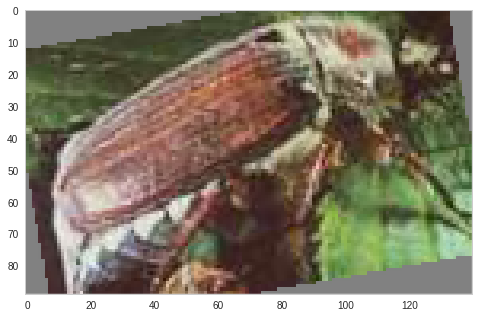

In [38]:

def rand_img(img):
    height, width, depth = img.shape
    if random.choice((True,False)):
        img = np.fliplr(img)
    img = img[random.randint(0,crop_range):
              random.randint(height - crop_range,height),
              random.randint(0,crop_range):
              random.randint(width - crop_range,width)]
    img = transform.rotate(img,(random.random()-0.5) * 2 * angle_range, cval=127, resize=False,mode='constant',order=2)
    return img
plt.imshow(rand_img(io.imread(data['path'].ix[200])), interpolation='none')
plt.show()

## Trainings und Evaluierungsset erstellen

In [39]:
x_train_df = data[:0]
x_test_df  = data[:0]
for key, group in data.groupby('class'):
    x_train_df = x_train_df.append(group[0:nb_training_images])
    x_test_df  = x_test_df.append(group[nb_training_images:]) 
x_train_df.head()


def build_np(df, augment=0):
    nb_images = len(df) + len(df) * augment
    x = np.zeros((nb_images,) + img_shape, dtype=np.float32)
    y = np.zeros((nb_images,),dtype=np.int8)
    idx = 0
#     print(x.shape)
    for path, cId in tqdm(list(zip(df['path'],df['y']))):
        img = io.imread(path)
        x[idx] = preprocess(img)
        y[idx] = cId
        idx += 1
        for i in range(augment):
            aug_img = rand_img(img)
            x[idx] = preprocess(aug_img)
            y[idx] = cId
            idx += 1
    npy = np.zeros((len(y), max(y) + 1), dtype=np.bool)
    npy[np.arange(len(y)), y] = 1 
    return x, npy

x_train, y_train = build_np(x_train_df, augment=10)
x_test, y_test   = build_np(x_test_df)

with open('data/dataset.pickle', 'wb') as feat:
    pickle.dump((x_train, y_train, x_test, y_test), feat)

100%|██████████| 284/284 [00:02<00:00, 131.28it/s]


In [ ]:
with open('data/dataset.pickle', 'rb') as feat:
    x_train, y_train, x_test, y_test = pickle.load(feat)

## VGG16 Model laden
siehe https://arxiv.org/abs/1409.1556:

```
 Very Deep Convolutional Networks for Large-Scale Image Recognition
 Karen Simonyan, Andrew Zisserman
```

Abwandlung hier: letzter Layer wird nicht geladen

In [13]:
def load_some_weighs(model, weights_path):
    f = h5py.File(weights_path, mode='r')
    nb_layers = f.attrs['nb_layers']
    for k in range(len(model.flattened_layers)):
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.flattened_layers[k].set_weights(weights)

    f.close()
    return model

def VGG_16(weights_path=None, layer_limit=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    # img dim = 112
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    # img dim = 56
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    # img dim = 28
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    # img dim = 14
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    # img dim = 7
    model.add(Flatten())
    # length 25088
    if layer_limit == 'maxpool4':
        return load_some_weighs(model, weights_path)

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
 
    return load_some_weighs(model, weights_path)

In [40]:
f_model = VGG_16('models/vgg16/vgg16_weights.h5')
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
f_model.compile(optimizer=sgd, loss='categorical_crossentropy')

In [41]:
conv_model = VGG_16('models/vgg16/vgg16_weights.h5', layer_limit='maxpool4')
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
conv_model.compile(optimizer=sgd, loss='categorical_crossentropy')

# Filter des VGG Models

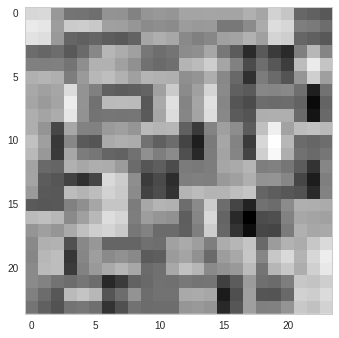

In [16]:
conv1 = f_model.layers[1]
img = np.zeros((8*3, 8*3))
for y in range(8):
    for x in range(8):
#         print(y,x, y*8+x)
        img[x*3:x*3+3,y*3:y*3+3] = conv1.get_weights()[0][y*8 + x,:,:,0]
plt.imshow(img, interpolation='none')
plt.show()

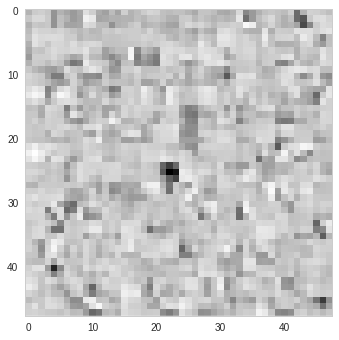

In [17]:
conv2 = f_model.layers[15]
dim = 16
img = np.zeros((dim*3, dim*3))
for y_f in range(dim):
    for x_f in range(dim):
        for y in range(dim):
            for x in range(dim):
        #         print(y,x, y*8+x)
                img[x*3:x*3+3,y*3:y*3+3] = conv2.get_weights()[0][y*dim + x,0,:,:]
plt.imshow(img, interpolation='none')
plt.show()

## Feature-Vektoren
CNN ist schwer zu trainieren (Viele Daten, Rechenaufwändig)

Aber: Gute Transferleistung 

In [43]:
dense_features_train = f_model.predict(x_train,verbose=1)
dense_features_test  = f_model.predict(x_test,verbose=1)
with open('models/vgg_dense.features', 'wb') as feat:
    pickle.dump((dense_features_train, dense_features_test), feat)

conv_features_train = conv_model.predict(x_train,verbose=1)
conv_features_test  = conv_model.predict(x_test,verbose=1)
with open('models/vgg_conv.features', 'wb') as feat:
    pickle.dump((conv_features_train, conv_features_test), feat)

284/284 [==============================] - 174s    


In [18]:
with open('models/vgg_dense.features', 'rb') as feat:
    dense_features_train, dense_features_test = pickle.load(feat)
with open('models/vgg_conv.features', 'rb') as feat:
    conv_features_train, conv_features_test = pickle.load(feat)

## Modelkonstruktion 1
CNN-Tensor als Feature (7, 7, 512)

In [81]:
t_model = Sequential()
t_model.add(Dense(71, input_shape=(25088,),activation='softmax'))
adam1 = Adam(lr=0.00003)
t_model.compile(optimizer=adam1, loss='categorical_crossentropy', metrics=['accuracy'])

t_model_multi = Sequential()
t_model_multi.add(Dense(4096, input_shape=(25088,),activation='relu'))
t_model_multi.add(Dropout(0.5))
t_model_multi.add(Dense(4096, activation='relu'))
t_model_multi.add(Dropout(0.5))
t_model_multi.add(Dense(71, activation='softmax'))
adam2 = Adam(lr=0.00003)
t_model_multi.compile(optimizer=adam2, loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
def train_model(model,n=1):
    history = model.fit(conv_features_train, y_train,
            verbose=0,
            shuffle=True,
            nb_epoch=10,
            batch_size=32)

    loss, acc = model.evaluate(conv_features_test,y_test, verbose=0)
    return history, loss, acc


In [82]:
t_model_eval = train_model(t_model)

In [91]:
batched_training = []
for idx in tqdm(range(12)):
    batched_training.append(train_model(t_model_multi,n=1))

100%|██████████| 12/12 [4:51:01<00:00, 2135.03s/it]


In [102]:
h = []
[h.extend(history.history['loss']) for history, loss, acc in batched_training]

[None, None, None, None, None, None, None, None, None, None, None, None]

## Trainingsergebniss
Sehr zeitaufwendig ohne GPU 

Schlechte Genauigkeit

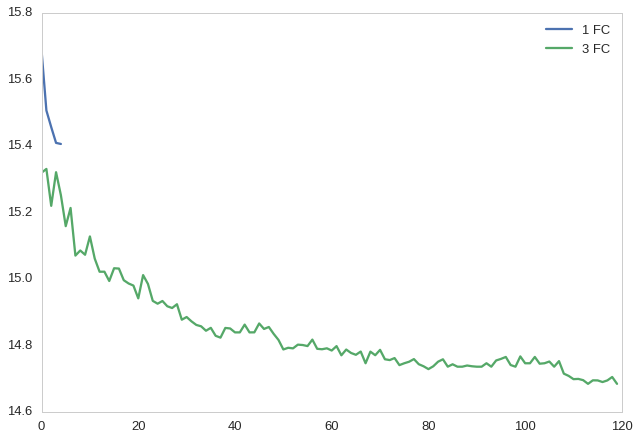

In [105]:
line, = plt.plot(t_model_eval[0].history['loss'], label="1 FC")
line, = plt.plot(h, label="3 FC")
plt.legend()

## Genauigkeit

In [111]:
evaluations = []
loss, acc = t_model.evaluate(conv_features_test,y_test, verbose=1)
evaluations.append(('1 FC', loss, acc))
loss, acc = t_model_multi.evaluate(conv_features_test,y_test, verbose=1)
evaluations.append(('3 FC', loss, acc))
pd.DataFrame(evaluations, columns=['Name','Loss', 'Genauigkeit'])

284/284 [==============================] - 0s     


,Name,Loss,Genauigkeit
0,1 FC,12.929887,0.084507
1,3 FC,6.155772,0.556338


## Modelkonstruktion 2
Ausgabe des Fully Connected Layers als Feature (4096)

0.823943660293


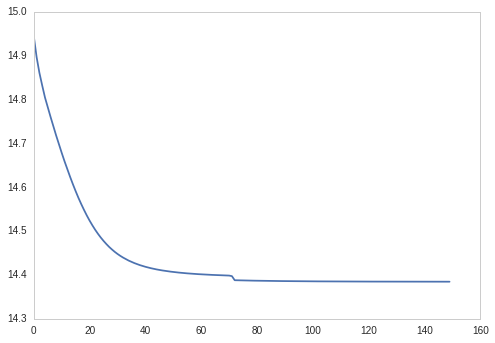

In [47]:
dense_model = Sequential()
dense_model.add(Dense(71, input_shape=(4096,),activation='softmax'))
adam = Adam(lr=0.000006)
dense_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = dense_model.fit(dense_features_train, y_train,
        verbose=0,
        shuffle=True,
        nb_epoch=150,
        batch_size=16)

loss, acc = dense_model.evaluate(dense_features_test,y_test, verbose=0)
print(acc)
plt.plot(history.history['loss'])
plt.show()

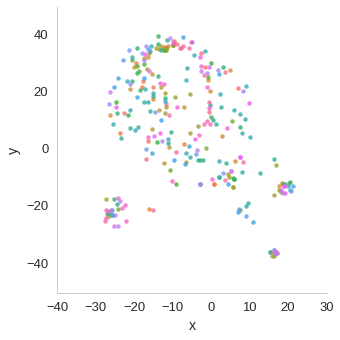

In [75]:
preds = dense_model.predict(dense_features_train)
pca = PCA(n_components=50)
pca.fit(preds)
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
transformed = tsne.fit_transform(pca.transform(preds)) 
data = pd.DataFrame(transformed, columns=['x', 'y'])
data['class'] = pd.Series(x_test_df['y'])
g = sns.lmplot(x='x', y='y', data=data, hue='class', fit_reg=False,legend=False)


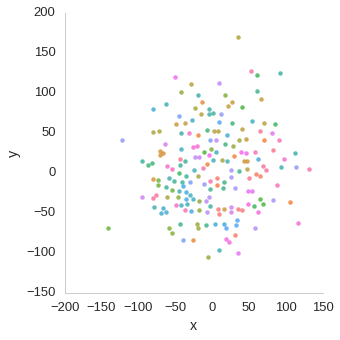

In [76]:
preds = dense_model.predict(dense_features_test)
pca.fit(preds)
np.set_printoptions(suppress=True)
transformed = tsne.fit_transform(pca.transform(preds)) 
data = pd.DataFrame(transformed, columns=['x', 'y'])
data['class'] = pd.Series(x_test_df['y'])
sns.lmplot(x='x', y='y', data=data, hue='class', fit_reg=False,legend=False)

## Was wird erkannt?

In [50]:
def gray_slide(test_img, y_test_img, n = 200, r = 20, step=5):
    coordinates = []
    for height, i in enumerate(range(r, test_img.shape[0] - r,step)):
        for width, j in enumerate(range(r, test_img.shape[1] - r,step)):
            coordinates.append((i,j))
    occluded = np.zeros((len(coordinates),) + img_shape, dtype=np.float32)
    idx = 0
    for idx in range(len(coordinates)):
            i, j = coordinates[idx]
            occ = test_img.copy()
            occ[i-r:i+r,j - r: j + r] = 127
            occluded[idx] = preprocess(occ)
#     occluded.shape
    x_o_class = dense_model.predict(f_model.predict(occluded))
#     co = np.array(coordinates)
#     z = np.concatenate((co, np.asmatrix(x_o_class[:,y_test_img]).transpose()),1)
    z = x_o_class[:,y_test_img]
    return np.reshape(z - z.mean(),(height + 1, width + 1))

In [305]:
gray_slide_img = gray_slide(io.imread(x_test_df['path'][n]), x_test_df['y'][n])

In [51]:
slide_image_paths = random.sample(list(zip(x_test_df['path'], x_test_df['y'])), 5)

In [52]:
slide_images = [gray_slide(io.imread(path), y) for path, y in tqdm(slide_image_paths)]

100%|██████████| 5/5 [24:13<00:00, 300.25s/it]


In [336]:
(slide_image_paths[0])

('./data/WebImages_71x6/himbeere_6.jpg', 25)

In [77]:
def plot_side_by_side(i):    
    plt.subplot(121)
    plt.imshow(io.imread(slide_image_paths[i][0]))
    plt.subplot(122)
    plt.imshow(slide_images[i],cmap='RdBu_r', interpolation='none')

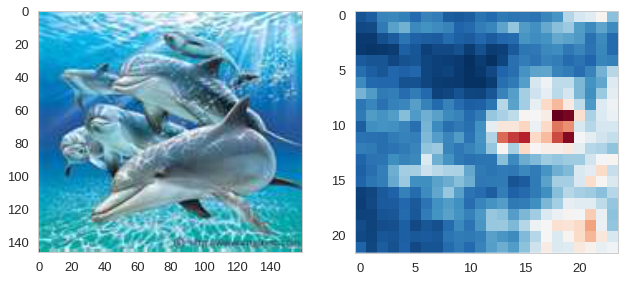

In [71]:
plot_side_by_side(0)   

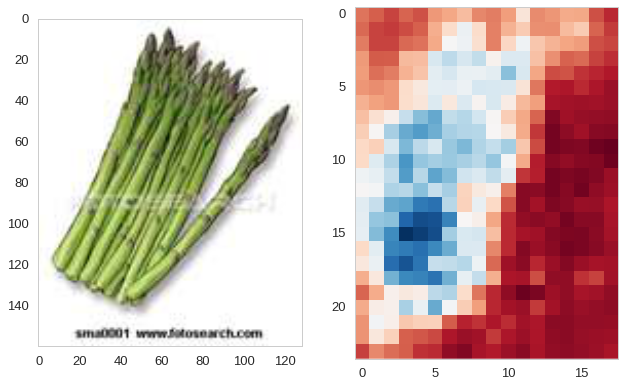

In [70]:
plot_side_by_side(1)

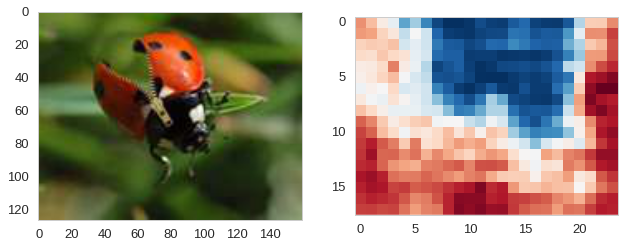

In [69]:
plot_side_by_side(2)

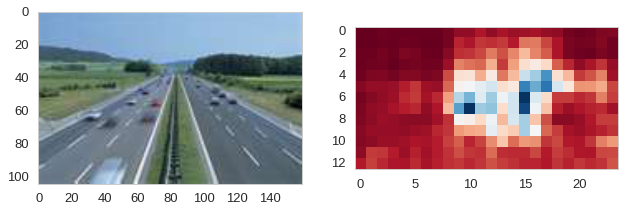

In [68]:
plot_side_by_side(3)

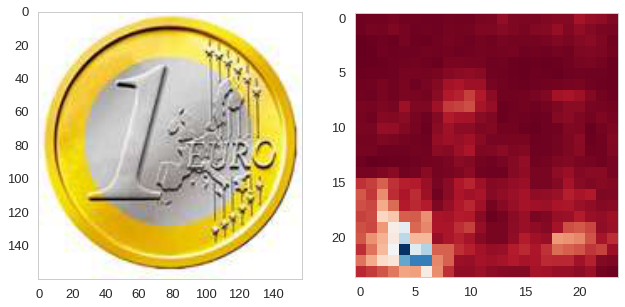

In [72]:
plot_side_by_side(4)

## mAP

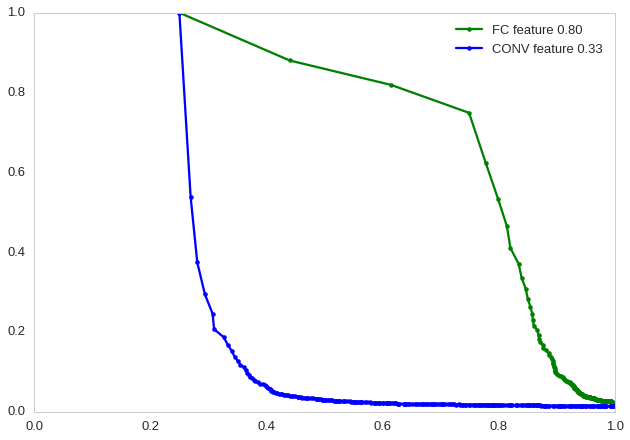

In [112]:
x_features = dense_model.predict(dense_features_test)
recal, pres, mAP = p_r_curve(x_features,np.array(x_test_df['y']),sdist.euclidean)
plt.plot(recal, pres,'.-g',label='FC feature {:.2f}'.format(mAP.mean()))

x_features = t_model.predict(conv_features_test)
recal, pres, mAP = p_r_curve(x_features,np.array(x_test_df['y']),sdist.euclidean)
plt.plot(recal, pres,'.-b', label='CONV feature {:.2f}'.format(mAP.mean()))

plt.xlim([0,1])
plt.ylim([0,1])
mAP.mean()
plt.legend()